In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import math
import xgboost as xgb
import shap
import optuna
from optuna import Trial
from sklearn.preprocessing import StandardScaler, LabelEncoder
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

/kaggle/input/playground-series-s3e26/sample_submission.csv
/kaggle/input/playground-series-s3e26/train.csv
/kaggle/input/playground-series-s3e26/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv').drop(columns=['id'])
test = pd.read_csv('/kaggle/input/playground-series-s3e26/test.csv').drop(columns=['id'])

In [ ]:
numeric_columns = train.select_dtypes(include='number').columns.tolist()
categorical_columns = train.select_dtypes(include='object').columns.tolist()
categorical_columns.remove('Status')

## Data Pre-Processing for Model Selection

In [12]:
# Encode target variable

# Creating a instance of label Encoder.
le = LabelEncoder()

# Using .fit_transform function to fit label
# encoder and return encoded label
train['Status'] = le.fit_transform(train['Status'])
le_name_mapping = dict(zip(le.transform(['C', 'D', 'CL']), ['Status_' + item for item in le.inverse_transform([0, 1, 2])]))

print(le_name_mapping)

{0: 'Status_C', 2: 'Status_CL', 1: 'Status_D'}


In [13]:
# Add stage to categorical columns
categorical_columns.append('Stage')
numeric_columns.remove('Stage')

In [14]:
# Create dummies for categorical variables
train = pd.get_dummies(train, columns=categorical_columns, drop_first=True, dtype=int)
test = pd.get_dummies(test, columns=categorical_columns, drop_first=True, dtype=int)

## Model Selection
Modelling will focus on predicting drop outs so the task will become binary classification.

In [15]:
X = train.drop(columns=['Status'], axis =1).values
y = train['Status'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.15, random_state=4131)

In [16]:
# Given I am planning on testing non-tree based classifiers, scale numeric data
scaler = StandardScaler()

column_indices = [train.columns.get_loc(col) for col in numeric_columns]
X_train[:, column_indices] = scaler.fit_transform(X_train[:, column_indices])
X_test[:, column_indices] = scaler.transform(X_test[:, column_indices])

In [17]:
def baseline_classification_models(X_train, y_train, X_test, y_test, random_state=42):
    """
    Fits and scores baseline binary classification models, and plots a bar chart with F1 scores.
    """
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=random_state),
        'Decision Tree': DecisionTreeClassifier(random_state=random_state),
        'Random Forest': RandomForestClassifier(random_state=random_state),
        'XGB Classifier': xgb.XGBClassifier(random_state=random_state),
        'LGBM': LGBMClassifier(random_state=random_state),
        'CatBoost': CatBoostClassifier(logging_level='Silent',random_state=random_state)
    }

    num_models = len(models)
    colors = plt.cm.viridis(np.linspace(0, 1, num_models))
    # Fit and score each model
    log_losses = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        
        y_pred = model.predict_proba(X_test)
        
        log_losses[model_name] = log_loss(y_test, y_pred)
        print(f"{model_name} - Log Loss: {log_loss(y_test, y_pred)}")

    # Plot the bar chart
    plt.bar(log_losses.keys(), log_losses.values(), color=colors)
    plt.xlabel('Models')
    plt.ylabel('Log Loss')
    plt.title('Baseline Binary Classification Models Performance')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Logistic Regression - Log Loss: 0.5279928414271419
Decision Tree - Log Loss: 9.481972898317498
Random Forest - Log Loss: 0.5177669035705501
XGB Classifier - Log Loss: 0.5119779817406673
LGBM - Log Loss: 0.47070593409570033
CatBoost - Log Loss: 0.4761803578783907


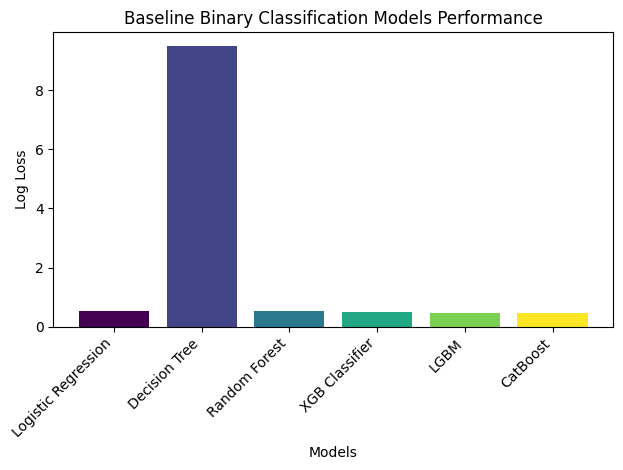

In [18]:
baseline_classification_models(X_train, y_train, X_test, y_test)

Prior to any hyperparameter tuning, the best model based on F1 score is the LGBM classifier, with the decision tree classifier being the worst.